



# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
!pip install -U scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
y_train

array([1, 0, 1, ..., 1, 1, 0])

In [5]:
y_train.shape

(7000,)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [6]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: DummyClassifier выдает случайные предсказания, не зависящие от 'X', но зависящие от 'y' в передаваемых аргументах! А с дополнительным параметром в strategy='uniform' наш классификатор выдает случайные предсказания с равной вероятностью для каждого класса.
В данном случае у нас два класса {0, 1} и поэтому они имеют равную вероятность в 0.5. Соответственно, в предсказаниях(predict_proba) для тестовой выборки содержатся вероятности пренадлежности классу 1, что и равно 0.5 для каждого объекта!

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [7]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


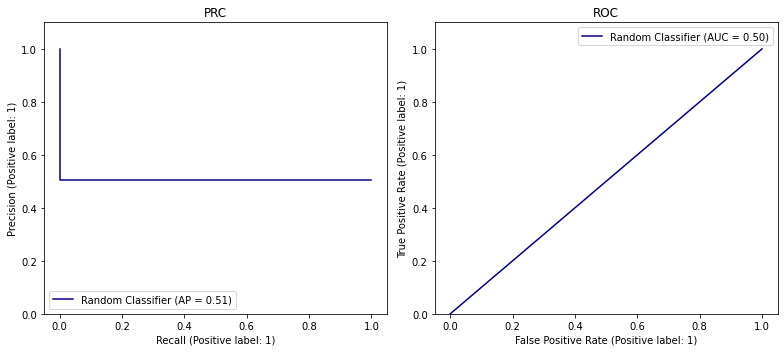

In [8]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')

  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name, color='navy')
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name, color='navy')
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [9]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [10]:
# отделим валидационную выборку

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [11]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import auc, precision_recall_curve

In [12]:
# Подберем параметр регуляризации C с точки зрения AUC-PR
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
auc_pr_values = []

for C in C_values:
    svm = SVC(kernel='linear', C=C, random_state=42, probability=True).fit(X_valid, y_valid)
    svm_pred = svm.predict_proba(X_valid)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_valid, svm_pred)
    auc_pr = auc(recall, precision)
    auc_pr_values.append(auc_pr)

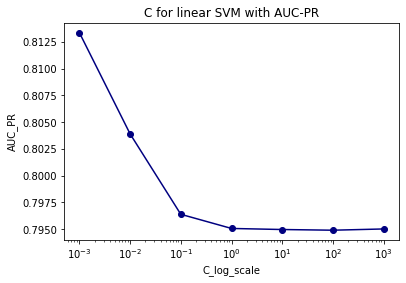

In [13]:
plt.plot(C_values, auc_pr_values, marker='o', color='navy')
plt.xlabel('C_log_scale')
plt.ylabel('AUC_PR')
plt.xscale('log')
plt.title('C for linear SVM with AUC-PR')
plt.show()


In [14]:
# обучим SVM уже на лучшем C

C_best_svm = C_values[auc_pr_values.index(max(auc_pr_values))]
# svm_linear_svc = LinearSVC(max_iter=100000, C=C, random_state=42).fit(X_train, y_train)
svm_linear_svc = SVC(kernel='linear', C=C_best_svm, random_state=42, probability=True).fit(X_train, y_train)
svm_linear_svc_prob = svm_linear_svc.predict_proba(X_test)[:, 1]
svm_linear_svc_pred = svm_linear_svc.predict(X_test)

print(f'With best C parametr = {C_best_svm}')

With best C parametr = 0.001


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM metrics
AUC-PR: 0.83104
AUC-ROC: 0.77148


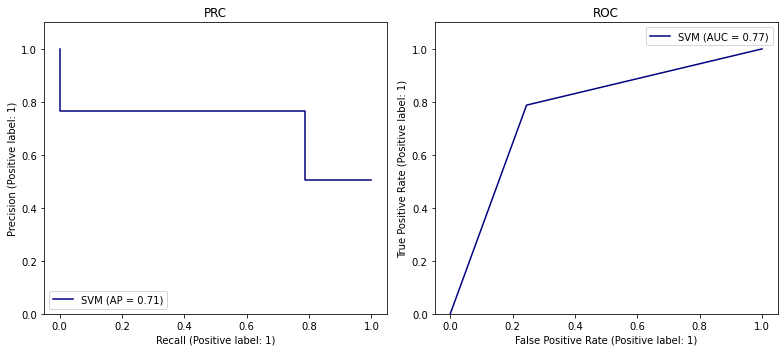

In [15]:
depict_pr_roc(y_test, svm_linear_svc_pred, 'SVM')

SVM metrics
AUC-PR: 0.81944
AUC-ROC: 0.84712


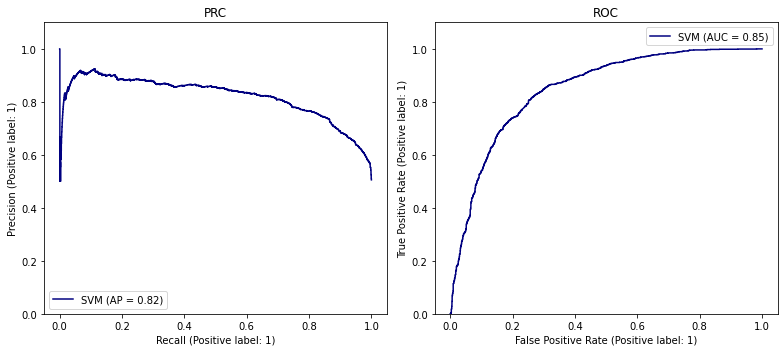

In [16]:
depict_pr_roc(y_test, svm_linear_svc_prob, 'SVM')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [17]:
# dataframe для сравнения
# методов классификации по метрикам

precision, recall, _ = precision_recall_curve(y_test, svm_linear_svc_pred)

# добавление очередной строки с характеристиками метода
df_metrics.loc['SVM Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, svm_linear_svc_pred),
      C_best_svm
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000
SVM Classifier,0.831041,0.771482,0.001


По комментариям можно добавить, что поведения двух кривых кардинально отличаются, что не удивительно! На протяжении всех отметок с 0 до 1 ROC планомерно рос, увеличивая тем самым площадь AUC-ROC, в то время как PR совсем по-немногу убывал. Из чего я предполагаю, что межклассовый дисбаланс не велик, так как AUC-PR описывает правильность классификации объектов с большими оценками, тогда как ROC-кривая — различие распределений объектов разных классов по оценкам.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, average_precision_score, accuracy_score, confusion_matrix

In [19]:
# Подберем параметр регуляризации C с точки зрения AUC-PR
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
auc_pr_values = []

for C in C_values:
#     lr = LogisticRegression(max_iter=100000, C=C, random_state=42).fit(X_valid, y_valid)
    lr = LogisticRegression(C=C, random_state=42).fit(X_valid, y_valid)
    lr_pred = lr.predict_proba(X_valid)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_valid, lr_pred)
    auc_pr = auc(recall, precision)
    auc_pr_values.append(auc_pr)

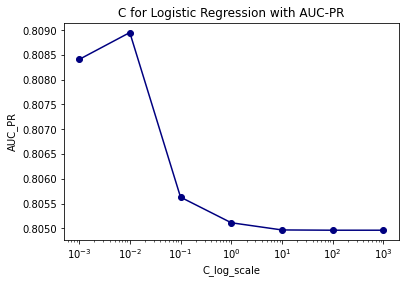

In [20]:
plt.plot(C_values, auc_pr_values, marker='o', color='navy')
plt.xlabel('C_log_scale')

plt.ylabel('AUC_PR')
plt.xscale('log')
plt.title('C for Logistic Regression with AUC-PR')
plt.show()

In [21]:
# обучим Logistic Regression уже на лучшем C

C_best_lr = C_values[auc_pr_values.index(max(auc_pr_values))]
# lr = LogisticRegression(max_iter=100000, C=C_best_lr, random_state=42).fit(X_train, y_train)
lr = LogisticRegression(C=C_best_lr, random_state=42).fit(X_train, y_train)
lr_prob = lr.predict_proba(X_test)[:, 1]
lr_pred = lr.predict(X_test)

print(f'With best C parametr = {C_best_lr}')

With best C parametr = 0.01


Logistic Regression metrics
AUC-PR: 0.83105
AUC-ROC: 0.77130


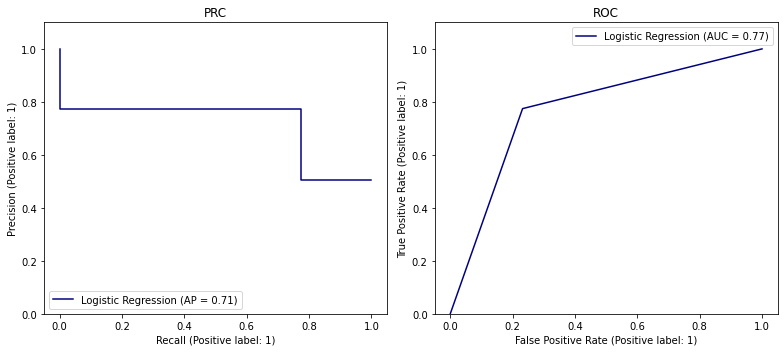

In [22]:
depict_pr_roc(y_test, lr_pred, 'Logistic Regression')

Logistic Regression metrics
AUC-PR: 0.82837
AUC-ROC: 0.84762


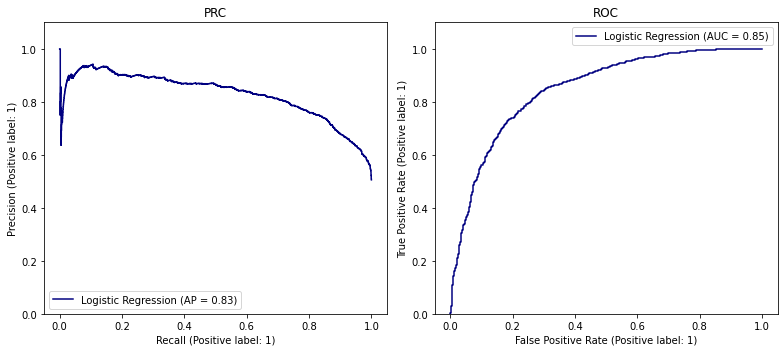

In [23]:
depict_pr_roc(y_test, lr_prob, 'Logistic Regression')

In [24]:
# dataframe для сравнения
# методов классификации по метрикам

precision, recall, _ = precision_recall_curve(y_test, lr_pred)

# добавление очередной строки с характеристиками метода
df_metrics.loc['Logistic Regression Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, svm_linear_svc_pred),
      C_best_lr
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000
SVM Classifier,0.831041,0.771482,0.001
Logistic Regression Classifier,0.831045,0.771482,0.010


In [25]:
# # Проделаю все вручную, а то не догоняю, что просят в задании
# # Построение ROC-кривой

# fpr, tpr, _ = roc_curve(y_test, lr_prob)
# roc_auc = auc(fpr, tpr)

# print('AUC-ROC: %.5f' % roc_auc)


# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

In [26]:
# # Построение PR-кривой

# precision, recall, _ = precision_recall_curve(y_test, lr_prob)
# average_precision = average_precision_score(y_test, lr_prob)
# auv_pr = auc(recall, precision)

# print('AUC-PR: %.5f' % auv_pr)

# plt.figure()
# plt.plot(recall, precision, color='darkorange', lw=2, label=f'PRC curve (area = {average_precision:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='upper right')
# plt.show()

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [27]:
precision_dummy, recall_dummy, _ = precision_recall_curve(y_test, y_random)
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_random)

precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_linear_svc_prob)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_linear_svc_prob)

precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr_prob)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)

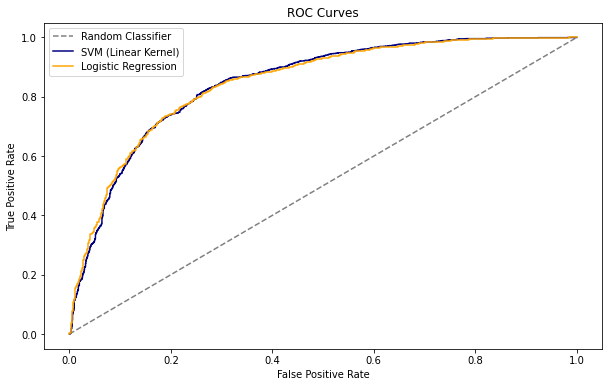

In [28]:
# Построение ROC-кривой

plt.figure(figsize=(10, 6))
plt.plot(fpr_dummy, tpr_dummy, linestyle='--', color='gray', label='Random Classifier')
plt.plot(fpr_svm, tpr_svm, color='navy', label='SVM (Linear Kernel)')
plt.plot(fpr_lr, tpr_lr, color='orange', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

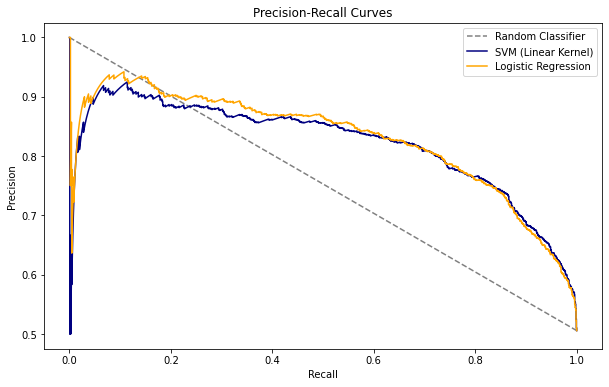

In [29]:
# Построение PR-кривой

plt.figure(figsize=(10, 6))
plt.plot(recall_dummy, precision_dummy, linestyle='--', color='gray', label='Random Classifier')
plt.plot(recall_svm, precision_svm, color='navy', label='SVM (Linear Kernel)')
plt.plot(recall_lr, precision_lr, color='orange', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Различий практически нет, все метрики качества ведут себя идентичным образом! Разве что в некоторых значениях Recall (с 0.0 по 0.6) Логистическая Регрессия имеет более высокий Precision. Полагаю, что так может быть потому что LR более чувствительна к дисбалансу.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [30]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [31]:
np.random.seed(42)

In [32]:
# Фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

In [33]:
# Обучим SVC
model = SVC(kernel='linear', random_state=42, probability=True).fit(X, y)
model_svc_prob = model.predict_proba(X)[:, 1]
svm_linear_svc_pred = model.predict(X)

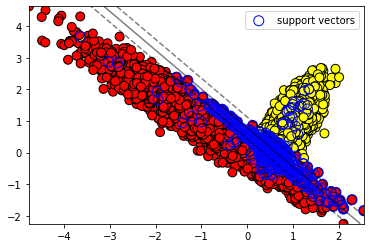

In [34]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0],
                X[:, 1],
                c=y,
                cmap='autumn',
                edgecolors='k',
                marker='o',
                s=80,
                linewidth=1)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** В контексте визуализации, они обозначаются как точки на границе классов, а иногда также внутри классов, если разделяющая полоса широка.
В нашем случае опорными векторами обозначаются синие круги между уровнями -1 и 1, ну и на 0 их самое большое скопление, что логично!

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [35]:
model_lr = LogisticRegression(random_state=42).fit(X, y)
lr_prob = model_lr.predict_proba(X)[:, 1]
lr_pred = model_lr.predict(X)

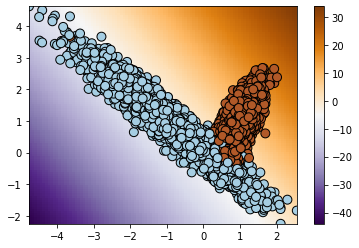

In [36]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0],
                X[:, 1],
                c=y,
                edgecolors='k',
                marker='o',
                s=80,
                linewidth=1,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model_lr)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:**  В данном случае, модель логистической регрессии считает объекты, находящиеся в этой области, как наиболее неопределенные, поскольку вероятность положительного ответа близка к 0.5.
На данной диаграмме эти "неуверенности" обозначаются в виде нежно-голубых кругов - граница принятия решений между двумя классами!
Теоретически это обосновывается тем, что логистическая регрессия моделирует вероятность принадлежности к классу (+1) для заданного вектора признаков X. Функция sigmoid, используемая в логистической регрессии, принимает значения между 0 и 1. Если вероятность положительного ответа близка к 0.5, то модель находится в зоне неопределенности относительно принятия решения, и можно сказать, что модель не уверена в принадлежности объекта к данному классу.
Там типо в формуле для регрессии степень exp будет близка к нулю -> вероятность близка к 0.5 (1/ 1 + exp(0))

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [37]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # по алгоритму (l + r) / 2, а не (l - r) / 2
        
        eps = 1e-8 # шум
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1) + eps) # заменим min на mean
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios,  marker='o')
    plt.ylim([-0.05, 1.05])
    plt.grid()

In [38]:
lr = LogisticRegression(C=C_best_lr, random_state=42).fit(X_train, y_train)
lr_prob = lr.predict_proba(X_test)[:, 1]
lr_pred = lr.predict(X_test)

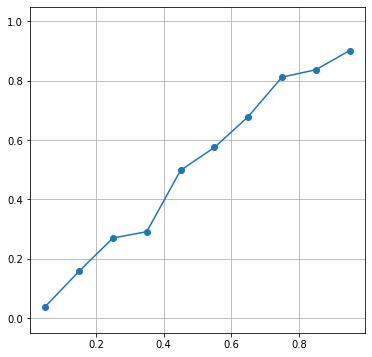

In [39]:
plot_calibration_curve(y_test, lr_prob)

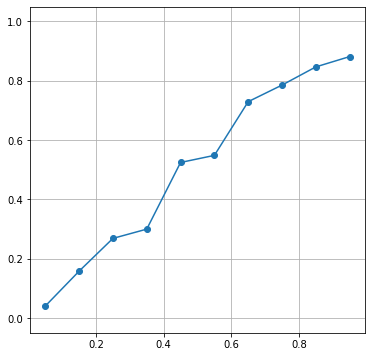

In [40]:
plot_calibration_curve(y_test, svm_linear_svc_prob)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [41]:
# C помощью верхней функции нарисовал сверху, а как мы рисовали на семе нарисовал ниже!

In [42]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

In [43]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
logreg_model = LogisticRegression(random_state=42).fit(X_train, y_train)
svm_model = SVC(kernel='linear', probability=True, random_state=42).fit(X_train, y_train)

In [45]:
y_prob_logreg = logreg_model.predict_proba(X_test)[:, 1]
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

In [46]:
prob_true_logreg, prob_pred_logreg = calibration_curve(y_test, y_prob_logreg, n_bins=10, strategy='uniform')
prob_true_svm, prob_pred_svm = calibration_curve(y_test, y_prob_svm, n_bins=10, strategy='uniform')
prob_true_diagonal = np.linspace(0, 1, 10)

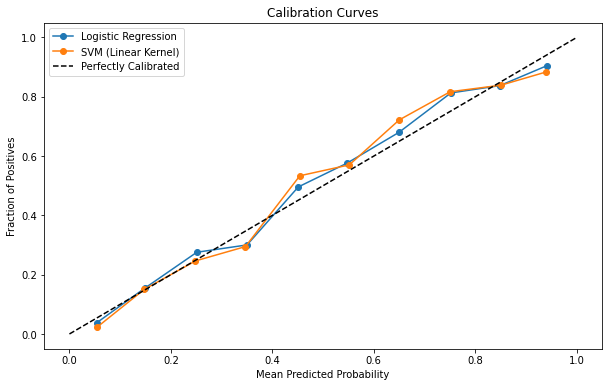

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_logreg, prob_true_logreg, marker='o', label='Logistic Regression')
plt.plot(prob_pred_svm, prob_true_svm, marker='o', label='SVM (Linear Kernel)')
plt.plot(prob_true_diagonal, prob_true_diagonal, linestyle='--', color='black', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves')
plt.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Да, результирующие кривые по обоим классификаторам получились откалиброваны и кривые диагональны! Не идеально, но хорошо приближены!

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

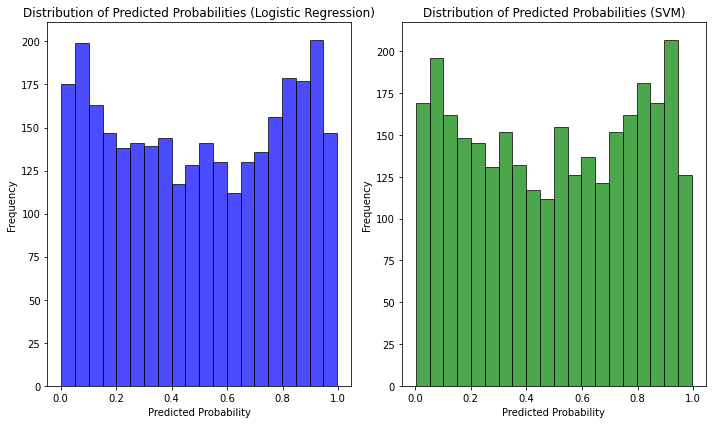

In [48]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(y_prob_logreg, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Predicted Probabilities (Logistic Regression)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y_prob_svm, bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Predicted Probabilities (SVM)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** По ощущениям SVM совсем слегка менее уверена в себе и дает не такие смелые предсказания, как LogReg. Это видно по столбцам по середине, куда соотносятся "сложные" элементы, которые трудно разнести по классам, у SVM они повыше. И по более низкому столбцу для вероятности равной 1 у SVM.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [49]:
# Внизу много того, что взято напрямую с семинарского ноута!

In [50]:
from sklearn.calibration import CalibratedClassifierCV

In [51]:
sigmoid_svc = CalibratedClassifierCV(svm_model, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8478773495795681


In [52]:
isotonic_svc = CalibratedClassifierCV(svm_model, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.8476144269197243


In [53]:
sigmoid_lr = CalibratedClassifierCV(logreg_model, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

Logistic regression ROC-AUC: 0.8479338012749194


In [54]:
isotonic_lr = CalibratedClassifierCV(logreg_model, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_lr_pred = isotonic_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, isotonic_lr_pred))

Logistic regression ROC-AUC: 0.8474237357598375


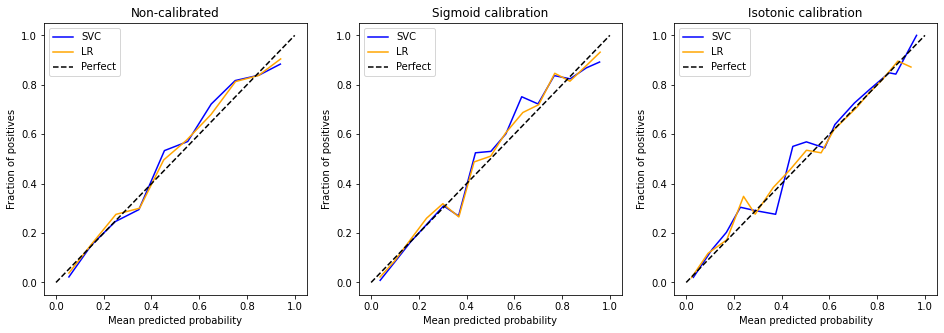

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

prob_true_logreg, prob_pred_logreg = calibration_curve(y_test, y_prob_logreg, n_bins=10, strategy='uniform')
prob_true_svm, prob_pred_svm = calibration_curve(y_test, y_prob_svm, n_bins=10, strategy='uniform')
prob_true_diagonal = np.linspace(0, 1, 10)

axs[0].plot(prob_pred_svm, prob_true_svm, label='SVC', color='blue')
axs[0].plot(prob_pred_logreg, prob_true_logreg, label='LR', color='orange')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='black')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, sigmoid_lr_pred, n_bins=15)

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='black')
axs[1].set_title('Sigmoid calibration')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, isotonic_lr_pred, n_bins=15)

axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='black')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** В сигмоидном методе совсем не улучшилась кривая, но вот изотоническом методе в начале, да, приближение хуже, чем в не калиброванном варианте, однако, затем очень даже отличные приближения для каждого классификатора!

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [56]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [57]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
# df = df.applymap(lambda x: 'undefined' if not x else x)
# df = df.applymap(lambda x: 'undefined' if (not x or pd.isna(x))  else x)

categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.fillna('undefined'))

display(df)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

# X_numerical = ['Income', 'Children', 'Cars', 'Age']
# X_categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Region', 'Commute Distance']

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,undefined,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


В начале поработаем только с категориальными признаками

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [59]:
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

In [60]:
ord_enc = OrdinalEncoder()

start_time = time.time()

X_train_enc = ord_enc.fit_transform(X_train)
X_test_enc = ord_enc.fit_transform(X_test)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_enc, y_train)

train_time = time.time() - start_time

y_pred_proba = lr_model.predict_proba(X_test_enc)[:, 1]
y_pred_pred = lr_model.predict(X_test_enc)

auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR после OrdinalEncoding: {auc_pr:.4f}")
print(f"Время обучения с учетом кодирования: {train_time:.4f} секунд")

AUC-PR после OrdinalEncoding: 0.5883
Время обучения с учетом кодирования: 0.0110 секунд


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [61]:
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

In [62]:
onehot_enc = OneHotEncoder()

start_time = time.time()

X_train_onehot = onehot_enc.fit_transform(X_train)
X_test_onehot = onehot_enc.fit_transform(X_test)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_onehot, y_train)

train_time = time.time() - start_time

y_pred_proba = lr_model.predict_proba(X_test_onehot)[:, 1]
y_pred_pred = lr_model.predict(X_test_onehot)

auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR после OneHotEncoder: {auc_pr:.4f}")
print(f"Время обучения с учетом кодирования: {train_time:.4f} секунд")

AUC-PR после OneHotEncoder: 0.6666
Время обучения с учетом кодирования: 0.0241 секунд


**Комментарий:** Легко заметить, что OneHotEncoder улучшило качество нашей модели по метрике AUC-PR в сравнении с OrdinalEncoder кодированием, но и времени на обучение с кодированием понадобилось чуть больше!

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [63]:
X_train

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,Married,Female,Bachelors,Clerical,Yes,0-1 Miles,Europe
540,Single,Female,Graduate Degree,Management,Yes,1-2 Miles,North America
110,Single,Female,Partial College,Manual,No,0-1 Miles,Europe
902,Single,Male,Bachelors,Skilled Manual,Yes,2-5 Miles,North America
15,Single,Female,High School,Manual,Yes,0-1 Miles,Europe
...,...,...,...,...,...,...,...
483,Married,Male,Graduate Degree,Clerical,Yes,0-1 Miles,Europe
375,Married,Female,Bachelors,Skilled Manual,Yes,0-1 Miles,Europe
968,Single,Male,Partial High School,Clerical,No,5-10 Miles,North America
756,Married,Male,Bachelors,Skilled Manual,No,0-1 Miles,North America


In [64]:
X_train_mntar = X_train.copy()
X_test_mntar = X_test.copy()

X_train['Purchased Bike'] = y_train
X_test['Purchased Bike'] = y_test

# display(X_train_mntar)
# display(X_test_mntar)

start_time = time.time()

for column in X_train_mntar.columns:
    mean_target = X_train.groupby(column)['Purchased Bike'].mean()
    X_train_mntar[column] = X_train[column].map(mean_target)
    X_test_mntar[column] = X_test[column].map(mean_target)

# X_train_mntar.drop(columns=['Purchased Bike'], axis=1)
# X_test_mntar.drop(columns=['Purchased Bike'], axis=1)

# display(X_train_mntar)
# display(X_test_mntar)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_mntar, y_train)

train_time = time.time() - start_time

y_pred_proba = lr_model.predict_proba(X_test_mntar)[:, 1]
y_pred_pred = lr_model.predict(X_test_mntar)

auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR после Mean-target Encoding: {auc_pr:.4f}")
print(f"Время обучения с учетом кодирования: {train_time:.4f} секунд")

AUC-PR после Mean-target Encoding: 0.6575
Время обучения с учетом кодирования: 0.0189 секунд


**Комментарий:** По времени мы все также дольше OrdinalEncoder, но чуть быстрее чем OneHotEncoder! А качество модели получилось немного хуже, чем у OneHotEncoder.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [65]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [66]:
X_train_mntar_with_eps = X_train_mntar.copy()
X_test_mntar_with_eps = X_test_mntar.copy()
eps = 0.001

start_time = time.time()

for column in X_train_mntar_with_eps.columns:
    X_train_mntar_with_eps[column] = (X_train_mntar_with_eps[column] * (1 + eps * np.random.randn(len(X_train_mntar_with_eps[column]))))
    X_test_mntar_with_eps[column] = (X_test_mntar_with_eps[column] * (1 + eps * np.random.randn(len(X_test_mntar_with_eps[column]))))

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_mntar_with_eps, y_train)

train_time = time.time() - start_time

y_pred_proba = lr_model.predict_proba(X_test_mntar_with_eps)[:, 1]
y_pred_pred = lr_model.predict(X_test_mntar_with_eps)

auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR после Mean-target Encoding: {auc_pr:.4f}")
print(f"Время обучения с учетом кодирования: {train_time:.4f} секунд")

AUC-PR после Mean-target Encoding: 0.6553
Время обучения с учетом кодирования: 0.0190 секунд


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Да, помогло! Добавление шума помогает вводить некоторую степень случайности в значения счётчиков, что может сделать модель менее склонной к заучиванию шумов в данных. Но важен баланс между борьбой с переобучением и сохранением информации из признаков.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [67]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [70]:
def smoothing_counters(train, target, column, C=10):
    global_mean = target.mean()
    
    train[target.name] = target
    
    enc = train.groupby(column)[target.name].agg(['count', 'mean'])
    count = enc['count']
    mean = enc['mean']
    smoothed_mean = (count * mean + C * global_mean) / (count + C)
    
    train.drop(columns=[target.name], axis=1, inplace=True)
    
    return train[column].map(smoothed_mean)    

In [71]:
# res = smoothing_counters(X_train, y_train, "Marital Status", 10)
# res

In [72]:
def train_smoothing_enc(X_train, X_test, y_train, y_test, C):
    X_train_smoothed = X_train.copy()
    X_test_smoothed = X_test.copy()
    
    for column in X_train.columns:
        if (column != 'Purchased Bike'):
            X_train_smoothed[column] = smoothing_counters(X_train, y_train, column, C)
        
#     X_train_smoothed.drop(columns=[y_train.name], axis=1, inplace=True)
    
    lr_model_smoothed = LogisticRegression(random_state=42)
    lr_model_smoothed.fit(X_train_smoothed, y_train)
    
    for column in X_test.columns:
        if (column != 'Purchased Bike'):
            X_test_smoothed[column] = smoothing_counters(X_test, y_test, column, C)
    
#     X_test_smoothed.drop(columns=[y_test.name], axis=1, inplace=True)
    
    y_prob_smoothed = lr_model_smoothed.predict_proba(X_test_smoothed)[:, 1]
    
    auc_pr_smoothed = average_precision_score(y_test, y_prob_smoothed)
    
    print(f"C: {C} and AUC-PR: {auc_pr_smoothed}")
    
    return auc_pr_smoothed, X_train_smoothed, X_test_smoothed

In [73]:
C_best = 0
auc_pr_best = 0
C_values = [0.1, 1, 5, 10, 20, 50]
X_train_smoothed_best = None
X_test_smoothed_best = None

start_time = time.time()

for C in C_values:
    auc_pr_smoothed, X_tr, X_te = train_smoothing_enc(X_train, X_test, y_train, y_test, C)
    if auc_pr_smoothed > auc_pr_best:
        auc_pr_best = auc_pr_smoothed
        C_best = C
        X_train_smoothed_best = X_tr
        X_test_smoothed_best = X_te

train_time = time.time() - start_time
        
print(f"Лучший параметр C = {C_best}")
print(f"Время обучения с учетом кодирования: {train_time:.4f} секунд")

C: 0.1 and AUC-PR: 0.7225779087793841
C: 1 and AUC-PR: 0.7207741182593552
C: 5 and AUC-PR: 0.7170280328521508
C: 10 and AUC-PR: 0.718267992165573
C: 20 and AUC-PR: 0.7185110222528774
C: 50 and AUC-PR: 0.7163476721616701
Лучший параметр C = 0.1
Время обучения с учетом кодирования: 0.2185 секунд


In [74]:
# На сколько понимаю тут тоже есть утечка таргета, поэтому добавим чутка шума для С=0.1
X_train_mntar_with_eps = X_train_smoothed_best.copy()
X_test_mntar_with_eps = X_test_smoothed_best.copy()
eps = 0.01

start_time = time.time()

for column in X_train_mntar_with_eps.columns:
    X_train_mntar_with_eps[column] = (X_train_mntar_with_eps[column] * (1 + eps * np.random.randn(len(X_train_mntar_with_eps[column]))))
    X_test_mntar_with_eps[column] = (X_test_mntar_with_eps[column] * (1 + eps * np.random.randn(len(X_test_mntar_with_eps[column]))))

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_mntar_with_eps, y_train)

train_time = time.time() - start_time

y_pred_proba = lr_model.predict_proba(X_test_mntar_with_eps)[:, 1]
y_pred_pred = lr_model.predict(X_test_mntar_with_eps)

auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR после Сглаживания таргета и добавления шума: {auc_pr:.4f}")
print(f"Время обучения с учетом кодирования: {train_time:.4f} секунд")

AUC-PR после Сглаживания таргета и добавления шума: 0.7261
Время обучения с учетом кодирования: 0.0102 секунд


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [75]:
from sklearn.model_selection import train_test_split
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical, y, test_size=0.25, random_state=777, stratify=y)

In [76]:
X_train_num.isna().sum()

ID          0
Income      5
Children    6
Cars        7
Age         5
dtype: int64

In [77]:
X_test_num.isna().sum()

ID          0
Income      1
Children    2
Cars        2
Age         3
dtype: int64

In [78]:
X_train_num = X_train_num.apply(lambda x: x.fillna(x.mean()))
X_test_num = X_test_num.apply(lambda x: x.fillna(x.mean()))

In [79]:
X_train_num.isna().sum()

ID          0
Income      0
Children    0
Cars        0
Age         0
dtype: int64

In [80]:
X_test_num.isna().sum()

ID          0
Income      0
Children    0
Cars        0
Age         0
dtype: int64

In [81]:
X_train_last = pd.concat([X_train_mntar_with_eps, X_train_num], axis=1)
X_test_last = pd.concat([X_test_mntar_with_eps, X_test_num], axis=1)

X_train_last.drop(columns=['ID'], axis=1, inplace=True)
X_test_last.drop(columns=['ID'], axis=1, inplace=True)

In [82]:
display(X_train_last)
display(X_test_last)

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,Income,Children,Cars,Age
345,0.418701,0.503982,0.533950,0.481556,0.472961,0.541852,0.488426,20000.000000,1.0,0.0,50.0
540,0.542787,0.501610,0.549090,0.439242,0.480671,0.456389,0.432361,70000.000000,3.0,2.0,52.0
110,0.556560,0.503280,0.439388,0.479873,0.494702,0.533805,0.480501,56120.805369,1.0,0.0,46.0
902,0.551319,0.466473,0.519601,0.479477,0.482214,0.566360,0.426136,80000.000000,3.0,0.0,40.0
15,0.556520,0.510591,0.465452,0.488536,0.483790,0.535645,0.487645,10000.000000,2.0,1.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...
483,0.412075,0.459949,0.546795,0.484492,0.481514,0.535480,0.485455,10000.000000,1.0,0.0,70.0
375,0.421335,0.503648,0.529269,0.478078,0.480605,0.546125,0.476758,40000.000000,1.0,1.0,89.0
968,0.554232,0.461901,0.329733,0.480282,0.474423,0.433635,0.433104,30000.000000,0.0,2.0,27.0
756,0.418471,0.454110,0.526280,0.469875,0.490734,0.536342,0.439642,40000.000000,1.0,1.0,36.0


,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,Income,Children,Cars,Age
202,0.500092,0.529588,0.482491,0.534951,0.467296,0.419045,0.504825,40000.0,2.0,1.427419,33.0
462,0.467653,0.447747,0.625695,0.539078,0.471141,0.588277,0.505575,40000.0,0.0,0.000000,39.0
652,0.469952,0.528212,0.479626,0.613894,0.501452,0.241588,0.440030,70000.0,5.0,3.000000,45.0
679,0.462797,0.522991,0.626902,0.330065,0.463080,0.322702,0.442288,60000.0,4.0,2.000000,60.0
606,0.500253,0.521518,0.621939,0.367256,0.461512,0.631287,0.441726,40000.0,2.0,0.000000,36.0
...,...,...,...,...,...,...,...,...,...,...,...
43,0.476478,0.445792,0.491149,0.629531,0.500162,0.243146,0.508980,170000.0,4.0,3.000000,48.0
463,0.501618,0.531090,0.362415,0.407802,0.463957,0.575211,0.507960,20000.0,2.0,1.000000,40.0
693,0.495807,0.452414,0.620392,0.373757,0.510382,0.572625,0.440186,60000.0,4.0,2.000000,41.0
677,0.473881,0.521367,0.534441,0.372323,0.505631,0.584543,0.442734,60000.0,4.0,0.000000,47.0


In [83]:
X_train_last.isna().sum()

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
Income              0
Children            0
Cars                0
Age                 0
dtype: int64

In [84]:
X_test_last.isna().sum()

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
Income              0
Children            0
Cars                0
Age                 0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [85]:
X = pd.concat([X_train_last, X_test_last])

In [86]:
X.nunique()

Marital Status      1000
Gender              1000
Education           1000
Occupation          1000
Home Owner          1000
Commute Distance    1000
Region              1000
Income                18
Children               8
Cars                   7
Age                   55
dtype: int64

In [87]:
X_numeric = ['Income', 'Children', 'Cars', 'Age']

In [88]:
X_train_last_counters = X_train_last.copy()
X_test_last_counter = X_test_last.copy()

X_train_last['Purchased Bike'] = y_train
X_test_last['Purchased Bike'] = y_test

start_time = time.time()

for column in X_numeric:
    mean_target_train = X_train_last.groupby(column)['Purchased Bike'].mean()
    X_train_last_counters[column] = X_train_last[column].map(mean_target_train)

    mean_target_test = X_test_last.groupby(column)['Purchased Bike'].mean()
    X_test_last_counter[column] = X_test_last[column].map(mean_target_test)

    
display(X_train_last_counters)
display(X_test_last_counter)
    
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_last_counters, y_train)

train_time = time.time() - start_time

y_pred_proba = lr_model.predict_proba(X_test_last_counter)[:, 1]
y_pred_pred = lr_model.predict(X_test_last_counter)

auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR после Mean-target Encoding: {auc_pr:.4f}")
print(f"Время обучения с учетом кодирования: {train_time:.4f} секунд")

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,Income,Children,Cars,Age
345,0.418701,0.503982,0.533950,0.481556,0.472961,0.541852,0.488426,0.415094,0.568000,0.610465,0.500000
540,0.542787,0.501610,0.549090,0.439242,0.480671,0.456389,0.432361,0.520408,0.571429,0.387218,0.750000
110,0.556560,0.503280,0.439388,0.479873,0.494702,0.533805,0.480501,1.000000,0.568000,0.610465,0.500000
902,0.551319,0.466473,0.519601,0.479477,0.482214,0.566360,0.426136,0.342857,0.571429,0.610465,0.344828
15,0.556520,0.510591,0.465452,0.488536,0.483790,0.535645,0.487645,0.425926,0.459627,0.555000,0.769231
...,...,...,...,...,...,...,...,...,...,...,...
483,0.412075,0.459949,0.546795,0.484492,0.481514,0.535480,0.485455,0.425926,0.568000,0.610465,0.250000
375,0.421335,0.503648,0.529269,0.478078,0.480605,0.546125,0.476758,0.588235,0.568000,0.555000,0.000000
968,0.554232,0.461901,0.329733,0.480282,0.474423,0.433635,0.433104,0.410000,0.515000,0.387218,0.350000
756,0.418471,0.454110,0.526280,0.469875,0.490734,0.536342,0.439642,0.588235,0.568000,0.555000,0.848485


,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,Income,Children,Cars,Age
202,0.500092,0.529588,0.482491,0.534951,0.467296,0.419045,0.504825,0.558824,0.479167,0.500000,0.600000
462,0.467653,0.447747,0.625695,0.539078,0.471141,0.588277,0.505575,0.558824,0.486486,0.636364,0.625000
652,0.469952,0.528212,0.479626,0.613894,0.501452,0.241588,0.440030,0.560000,0.210526,0.428571,0.333333
679,0.462797,0.522991,0.626902,0.330065,0.463080,0.322702,0.442288,0.520833,0.500000,0.276316,0.000000
606,0.500253,0.521518,0.621939,0.367256,0.461512,0.631287,0.441726,0.558824,0.479167,0.636364,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
43,0.476478,0.445792,0.491149,0.629531,0.500162,0.243146,0.508980,0.500000,0.500000,0.428571,0.714286
463,0.501618,0.531090,0.362415,0.407802,0.463957,0.575211,0.507960,0.428571,0.479167,0.611940,0.545455
693,0.495807,0.452414,0.620392,0.373757,0.510382,0.572625,0.440186,0.520833,0.500000,0.276316,0.307692
677,0.473881,0.521367,0.534441,0.372323,0.505631,0.584543,0.442734,0.520833,0.500000,0.636364,0.428571


AUC-PR после Mean-target Encoding: 0.8337
Время обучения с учетом кодирования: 0.0373 секунд


**Комментарий:** Да, стало, удивительно, намного лучше!

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ **Плюсы:** 1) Эффективность с категориальными признаками с большим числом уникальных значений: В случаях, когда у категориальных признаков много уникальных значений, one-hot-кодирование может привести к разрастанию размерности данных. Счётчики позволяют учесть информацию о целевой переменной, не увеличивая размерность. 2) Способность улавливать взаимосвязи с целевой переменной: Счётчики могут учесть статистику по целевой переменной для каждой уникальной категории, что может быть полезно при наличии взаимосвязей между категориями и целевой переменной, но тут важно не перебарщивать и разбавлять шумами
**Минусы:** 1) Возможность переобучения: Счётчики могут вызвать переобучение, особенно если в выборке есть категории с небольшим количеством объектов(на помощь приходит сглаживание и шумы) 2) Чувствительность к шуму!

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [89]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-26 16:36:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.6’

adult.data.6            [      <=>           ]   3.79M  2.48MB/s    in 1.5s    

2023-11-26 16:36:52 (2.48 MB/s) - ‘adult.data.6’ saved [3974305]



In [90]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
22239,41,Private,45156,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Male,2174,0,41,United-States,0


In [91]:
df.shape

(32561, 15)

In [92]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int32
dtype: object

In [93]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [94]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [95]:
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [96]:
y = df['income']
X = df.drop(columns=['income'], axis=1)

In [97]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']

In [98]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

X_numerical = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

In [99]:
prev_num_cat_features = X[categorical_columns].shape[1]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', 'passthrough', numerical),
])

X = column_transformer.fit_transform(X)

new_num_cat_features = X.shape[1] - prev_num_cat_features - len(numerical_columns)
print("Количество новых признаков после One-Hot Encoding:", new_num_cat_features)

Количество новых признаков после One-Hot Encoding: 94


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [101]:
X_train.shape

(24420, 108)

In [102]:
X_test.shape

(8141, 108)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [103]:
# КАКОЙ-ТО НЕЛОГИЧНЫЙ ПОРЯДОК ЗАДАНИЙ, ДАВАЙТЕ ВЕРНЕМСЯ ДО РАЗДЕЛЕНИЯ НА ТЕСТ И ТРЕЙН И ЗАКОДИРУЕМ ИНАЧЕМ ИХ ПОТОМ НЕ СМЕРЖИТЬ

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, precision_recall_curve

In [105]:
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train, y_train)

y_prob = logreg.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall, precision)

print(f"AUC-PR на тестовой выборке для модели LogisticRegression: {auc_pr}")

AUC-PR на тестовой выборке для модели LogisticRegression: 0.4503318285414827


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [106]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

In [107]:
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=777)

start_time = time.time()

select_fm = SelectFromModel(estimator=logreg_l1, max_features=40)

X_selected_train = select_fm.fit_transform(X_train, y_train)
X_selected_test = select_fm.transform(X_test)

select_finish_time = time.time() - start_time

logreg_l1.fit(X_selected_train, y_train)

y_prob = logreg_l1.predict_proba(X_selected_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall, precision)

print(f"AUC-PR на самых 40 важных данных для модели LogisticRegression: {auc_pr:.5f}")
print(f"Скорость такого отбора признаков: {select_finish_time:.5f} секунд")

AUC-PR на самых 40 важных данных для модели LogisticRegression: 0.62494
Скорость такого отбора признаков: 0.07123 секунд


Изменилось ли качество? Как?

**Да, качество улучшилось, аж почти на две десятых!**

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [109]:
y = df['income']
X = df.drop(columns=['income'], axis=1)

In [110]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']

In [111]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

X_numerical = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

In [112]:
prev_num_cat_features = X[categorical_columns].shape[1]
prev_X = X.copy()
# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
#     ('scaling', StandardScaler(), numerical),
# ])

# X = column_transformer.fit_transform(X)
# cols = column_transformer.get_feature_names_out(input_features=categorical)
# X = pd.DataFrame(X, cols)

onehot_enc = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

onehot_X = onehot_enc.fit_transform(X[categorical])
columns = onehot_enc.get_feature_names_out(input_features=categorical)
new_X = pd.DataFrame(onehot_X, columns=columns)

new_X.loc[:, numerical] = scaler.fit_transform(X[numerical])


new_num_cat_features = new_X.shape[1] - prev_num_cat_features - len(numerical_columns)
print("Количество новых признаков после One-Hot Encoding:", new_num_cat_features)

Количество новых признаков после One-Hot Encoding: 94


In [113]:
column_names = new_X.columns
column_names

Index(['workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th',
       ...
       'native-country_ Trinadad&Tobago', 'native-country_ United-States',
       'native-country_ Vietnam', 'native-country_ Yugoslavia', 'age',
       'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', length=108)

In [114]:
new_X

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,...,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [115]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.25, random_state=777, stratify=y)

In [116]:
X_train.shape

(24420, 108)

In [117]:
X_test.shape

(8141, 108)

In [118]:

logreg = LogisticRegression(max_iter=100000, random_state=777)
logreg.fit(X_train, y_train)

y_prob = logreg.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall, precision)

print(f"AUC-PR на тестовой выборке для модели LogisticRegression с уже отмасштабированными данными: {auc_pr}")

AUC-PR на тестовой выборке для модели LogisticRegression с уже отмасштабированными данными: 0.767133078263785


**Комментарий:** После скейлинга данных, но до отбора самых качественных признаков, модель значительно улучшила показатели в сравнении с самым первым опытом)

In [119]:
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=777)

start_time = time.time()

select_fm = SelectFromModel(estimator=logreg_l1, max_features=40)

X_selected_train = select_fm.fit_transform(X_train, y_train)
X_selected_test = select_fm.transform(X_test)

select_finish_time = time.time() - start_time

logreg_l1.fit(X_selected_train, y_train)

y_prob = logreg_l1.predict_proba(X_selected_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall, precision)

print(f"AUC-PR на самых 40 важных признаках и после нормирования для модели LogisticRegression: {auc_pr:.5f}\n")
print(f"Скорость такого отбора признаков: {select_finish_time:.5f} секунд\n")
print("Список всех признаков:\n")
last_columns = select_fm.get_feature_names_out(input_features=column_names)
last_features = pd.DataFrame(X_selected_train, columns=last_columns)
display(last_features.columns.values)

AUC-PR на самых 40 важных признаках и после нормирования для модели LogisticRegression: 0.75005

Скорость такого отбора признаков: 3.89177 секунд

Список всех признаков:



array(['workclass_ Federal-gov', 'workclass_ Without-pay',
       'education_ 1st-4th', 'education_ 5th-6th', 'education_ Preschool',
       'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'occupation_ ?', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Tech-support', 'relationship_ Husband',
       'relationship_ Other-relative', 'relationship_ Own-child',
       'relationship_ Wife', 'race_ Amer-Indian-Eskimo', 'sex_ Female',
       'native-country_ Cambodia', 'native-country_ Canada',
       'native-country_ Columbia', 'native-country_ Cuba',
       'native-country_ Dominican-Republic', 'native-country_ England',
       'n

**Комментарий:** Отобрали 40 самых значительных, но модель ухудшилась в своих показателях, AUC-PR уменьшился аж на одну сотую!

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [120]:
y = df['income']
X = df.drop(columns=['income'], axis=1)

In [121]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']
cat_num = categorical + numerical

In [122]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

X_numerical = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

In [123]:
prev_num_cat_features = X[categorical_columns].shape[1]
prev_X = X.copy()
# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
#     ('scaling', 'passthrough', numerical),
# ])
# X = column_transformer.fit_transform(X)

# scaler = StandardScaler(with_mean=False)
# X = scaler.fit_transform(X)

onehot_enc = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

onehot_X = onehot_enc.fit_transform(X[categorical])
columns = onehot_enc.get_feature_names_out(input_features=categorical)
new_X = pd.DataFrame(onehot_X, columns=columns)

new_X.loc[:, numerical] = scaler.fit_transform(X[numerical])
new_X.loc[:, columns] = scaler.fit_transform(new_X[columns])

new_num_cat_features = new_X.shape[1] - prev_num_cat_features - len(numerical_columns)
print("Количество новых признаков после One-Hot Encoding:", new_num_cat_features)

Количество новых признаков после One-Hot Encoding: 94


In [124]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.25, random_state=777, stratify=y)

In [125]:
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=777)

start_time = time.time()

select_fm = SelectFromModel(estimator=logreg_l1, max_features=40)

X_selected_train = select_fm.fit_transform(X_train, y_train)
X_selected_test = select_fm.transform(X_test)

select_finish_time = time.time() - start_time

logreg_l1.fit(X_selected_train, y_train)

y_prob = logreg_l1.predict_proba(X_selected_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall, precision)

print(f"AUC-PR на самых 40 важных признаках и после нормирования каждого признака для модели LogisticRegression: {auc_pr:.5f}")
print(f"Скорость такого отбора признаков: {select_finish_time:.5f} секунд")
print("Список всех признаков:\n")
last_columns = select_fm.get_feature_names_out(input_features=column_names)
last_features_last = pd.DataFrame(X_selected_train, columns=last_columns)
display(last_features_last.columns.values)

AUC-PR на самых 40 важных признаках и после нормирования каждого признака для модели LogisticRegression: 0.76561
Скорость такого отбора признаков: 9.93207 секунд
Список всех признаков:



array(['workclass_ Federal-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ Without-pay', 'education_ 5th-6th',
       'education_ Preschool', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Never-married', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'relationship_ Not-in-family',
       'relationship_ Own-child', 'relationship_ Unmarried',
       'relationship_ Wife', 'race_ Amer-Indian-Eskimo', 'race_ Black',
       'sex_ Female', 'sex_ Male', 'native-country_ Canada',
       'native-country_ Columbia', 'native-country_ Dominican-Republic',
       'native-country_ Germany',
       

In [126]:
# Сравним на признаки этот и предудыщий метод
set_diff = np.setdiff1d(last_features_last.columns.values, last_features.columns.values)
print("\nРазница между признаками в этом методе и предыдущем:\n",set_diff)


Разница между признаками в этом методе и предыдущем:
 ['age' 'capital-loss' 'fnlwgt'
 'native-country_ Outlying-US(Guam-USVI-etc)'
 'occupation_ Machine-op-inspct' 'occupation_ Sales' 'race_ Black'
 'relationship_ Not-in-family' 'relationship_ Unmarried' 'sex_ Male'
 'workclass_ Private' 'workclass_ Self-emp-inc'
 'workclass_ Self-emp-not-inc']


**Следовательно** признаки отобрались одинаковые!

**Комментарий:** Качетсво изменилось совсем незанчительно! Отсутствие масштабирования бинарных признаков не влияет на оценку весов в логистической регрессии, потому что изменение масштаба (умножение на константу) признаков не влияет на отношение шансов (odds) и, следовательно, не влияет на оценки коэффициентов логистической регрессии.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [127]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

In [128]:
y = df['income']
X = df.drop(columns=['income'], axis=1)

In [129]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']

In [130]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

X_numerical = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

In [131]:
from scipy.stats import t
def calculate_t_statistic(X_feature_values, y_values):
#     classes = np.unique(y_values)

    X_class_0 = X_feature_values[y_values == 0]
    X_class_1 = X_feature_values[y_values == 1]

#     mean_class_0 = csr_matrix.mean(X_class_0, axis=0)
#     mean_class_1 = csr_matrix.mean(X_class_1, axis=0)
    
    mean_0 = np.mean(X_class_0)
    mean_1 = np.mean(X_class_1)

    std_0 = np.std(X_class_0, ddof=1)
    std_1 = np.std(X_class_1, ddof=1)
    
    n_0 = len(X_class_0)
    n_1 = len(X_class_1)
    
    t_statistic = np.abs(mean_0 - mean_1) / np.sqrt(((std_0**2 * n_0) / (n_0 + n_1)) + ((std_1**2 * n_1) / (n_1 + n_0)))

    return t_statistic


In [132]:
# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
#     ('scaling', StandardScaler(), numerical),
# ])

# pipeline = Pipeline([
#     ('feature_selector', SelectKBest(score_func=calculate_t_statistic, k=40)),
#     ('classifier', LogisticRegression(max_iter=100000, random_state=777))
# ])

# X = column_transformer.fit_transform(X)

# scaler = StandardScaler(with_mean=False)
# X = scaler.fit_transform(X)

onehot_enc = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

onehot_X = onehot_enc.fit_transform(X[categorical])
columns = onehot_enc.get_feature_names_out(input_features=categorical)
new_X = pd.DataFrame(scaler.fit_transform(onehot_X), columns=columns)

new_X.loc[:, numerical] = scaler.fit_transform(X[numerical])
new_X.loc[:, columns] = scaler.fit_transform(new_X[columns])

num_features_to_select = 40
selected_features = []

select_start_time = time.time()

# display(new_X)
# display(y)

for column in new_X.columns:
#     display(new_X[column].values)
#     display(y_train.values)

    t_stat = calculate_t_statistic(new_X[column], y)

    selected_features.append((column, t_stat))

selected_features.sort(key=lambda x: x[1], reverse=True)
selected_features = [feature[0] for feature in selected_features[:num_features_to_select]]

select_finish_time = time.time() - start_time

the_best_X = new_X[selected_features]

print(f"Скорость такого отбора признаков: {select_finish_time:.5f} секунд")
print("Список всех признаков:\n")
# last_columns = select_fm.get_feature_names_out(input_features=column_names)
# last_features_last = pd.DataFrame(X_selected_train, columns=last_columns)
# display(last_features_last.columns.values)
display(selected_features)

Скорость такого отбора признаков: 11.05807 секунд
Список всех признаков:



['marital-status_ Married-civ-spouse',
 'relationship_ Husband',
 'education-num',
 'marital-status_ Never-married',
 'age',
 'hours-per-week',
 'relationship_ Own-child',
 'capital-gain',
 'sex_ Male',
 'sex_ Female',
 'occupation_ Exec-managerial',
 'relationship_ Not-in-family',
 'occupation_ Prof-specialty',
 'education_ Bachelors',
 'education_ Masters',
 'occupation_ Other-service',
 'education_ Prof-school',
 'capital-loss',
 'relationship_ Unmarried',
 'workclass_ Self-emp-inc',
 'education_ Doctorate',
 'education_ HS-grad',
 'marital-status_ Divorced',
 'relationship_ Wife',
 'occupation_ Adm-clerical',
 'race_ Black',
 'occupation_ Handlers-cleaners',
 'education_ 11th',
 'race_ White',
 'relationship_ Other-relative',
 'occupation_ ?',
 'workclass_ Private',
 'workclass_ ?',
 'marital-status_ Separated',
 'education_ 10th',
 'occupation_ Machine-op-inspct',
 'marital-status_ Widowed',
 'education_ Some-college',
 'native-country_ Mexico',
 'education_ 7th-8th']

In [133]:
display(the_best_X)

,marital-status_ Married-civ-spouse,relationship_ Husband,education-num,marital-status_ Never-married,age,hours-per-week,relationship_ Own-child,capital-gain,sex_ Male,sex_ Female,occupation_ Exec-managerial,relationship_ Not-in-family,occupation_ Prof-specialty,education_ Bachelors,education_ Masters,occupation_ Other-service,education_ Prof-school,capital-loss,relationship_ Unmarried,workclass_ Self-emp-inc,education_ Doctorate,education_ HS-grad,marital-status_ Divorced,relationship_ Wife,occupation_ Adm-clerical,race_ Black,occupation_ Handlers-cleaners,education_ 11th,race_ White,relationship_ Other-relative,occupation_ ?,workclass_ Private,workclass_ ?,marital-status_ Separated,education_ 10th,occupation_ Machine-op-inspct,marital-status_ Widowed,education_ Some-college,native-country_ Mexico,education_ 7th-8th
0,-0.922841,-0.825333,1.134739,1.431058,0.030671,-0.035429,-0.429346,0.148453,0.703071,-0.703071,-0.377746,1.708991,-0.381663,2.253993,-0.236374,-0.335541,-0.134196,-0.21666,-0.344032,-0.188389,-0.113344,-0.689942,-0.397508,-0.224927,2.763489,-0.325768,-0.209578,-0.193487,0.413020,-0.17625,-0.244944,-1.516792,-0.24445,-0.180285,-0.171753,-0.255954,-0.177358,-0.537144,-0.141934,-0.142272
1,1.083611,1.211632,1.134739,-0.698784,0.837109,-2.222153,-0.429346,-0.145920,0.703071,-0.703071,2.647285,-0.585141,-0.381663,2.253993,-0.236374,-0.335541,-0.134196,-0.21666,-0.344032,-0.188389,-0.113344,-0.689942,-0.397508,-0.224927,-0.361861,-0.325768,-0.209578,-0.193487,0.413020,-0.17625,-0.244944,-1.516792,-0.24445,-0.180285,-0.171753,-0.255954,-0.177358,-0.537144,-0.141934,-0.142272
2,-0.922841,-0.825333,-0.420060,-0.698784,-0.042642,-0.035429,-0.429346,-0.145920,0.703071,-0.703071,-0.377746,1.708991,-0.381663,-0.443657,-0.236374,-0.335541,-0.134196,-0.21666,-0.344032,-0.188389,-0.113344,1.449397,2.515672,-0.224927,-0.361861,-0.325768,4.771494,-0.193487,0.413020,-0.17625,-0.244944,0.659286,-0.24445,-0.180285,-0.171753,-0.255954,-0.177358,-0.537144,-0.141934,-0.142272
3,1.083611,1.211632,-1.197459,-0.698784,1.057047,-0.035429,-0.429346,-0.145920,0.703071,-0.703071,-0.377746,-0.585141,-0.381663,-0.443657,-0.236374,-0.335541,-0.134196,-0.21666,-0.344032,-0.188389,-0.113344,-0.689942,-0.397508,-0.224927,-0.361861,3.069667,4.771494,5.168316,-2.421192,-0.17625,-0.244944,0.659286,-0.24445,-0.180285,-0.171753,-0.255954,-0.177358,-0.537144,-0.141934,-0.142272
4,1.083611,-0.825333,1.134739,-0.698784,-0.775768,-0.035429,-0.429346,-0.145920,-1.422331,1.422331,-0.377746,-0.585141,2.620110,2.253993,-0.236374,-0.335541,-0.134196,-0.21666,-0.344032,-0.188389,-0.113344,-0.689942,-0.397508,4.445891,-0.361861,3.069667,-0.209578,-0.193487,-2.421192,-0.17625,-0.244944,0.659286,-0.24445,-0.180285,-0.171753,-0.255954,-0.177358,-0.537144,-0.141934,-0.142272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,1.083611,-0.825333,0.746039,-0.698784,-0.849080,-0.197409,-0.429346,-0.145920,-1.422331,1.422331,-0.377746,-0.585141,-0.381663,-0.443657,-0.236374,-0.335541,-0.134196,-0.21666,-0.344032,-0.188389,-0.113344,-0.689942,-0.397508,4.445891,-0.361861,-0.325768,-0.209578,-0.193487,0.413020,-0.17625,-0.244944,0.659286,-0.24445,-0.180285,-0.171753,-0.255954,-0.177358,-0.537144,-0.141934,-0.142272
32557,1.083611,1.211632,-0.420060,-0.698784,0.103983,-0.035429,-0.429346,-0.145920,0.703071,-0.703071,-0.377746,-0.585141,-0.381663,-0.443657,-0.236374,-0.335541,-0.134196,-0.21666,-0.344032,-0.188389,-0.113344,1.449397,-0.397508,-0.224927,-0.361861,-0.325768,-0.209578,-0.193487,0.413020,-0.17625,-0.244944,0.659286,-0.24445,-0.180285,-0.171753,3.906947,-0.177358,-0.537144,-0.141934,-0.142272
32558,-0.922841,-0.825333,-0.420060,-0.698784,1.423610,-0.035429,-0.429346,-0.145920,-1.422331,1.422331,-0.377746,-0.585141,-0.381663,-0.443657,-0.236374,-0.335541,-0.134196,-0.21666,2.906704,-0.188389,-0.113344,1.449397,-0.397508,-0.224927,2.763489,-0.325768,

In [134]:
X_train, X_test, y_train, y_test = train_test_split(the_best_X, y, test_size=0.25, random_state=777, stratify=y)

In [135]:
X_train.shape

(24420, 40)

In [136]:
X_test.shape

(8141, 40)

In [137]:
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

logreg = LogisticRegression(max_iter=100000, random_state=777)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

auc_pr = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.5f}")

AUC-PR: 0.52397


**Комментарий:** Качество модели почему-то резко ухудшилось, очень странно!

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [138]:
y = df['income']
X = df.drop(columns=['income'], axis=1)

In [139]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']

In [140]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

X_numerical = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

In [141]:
prev_num_cat_features = X[categorical_columns].shape[1]
prev_X = X.copy()

# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
#     ('scaling', 'passthrough', numerical),
# ])
# X = column_transformer.fit_transform(X)

# scaler = StandardScaler(with_mean=False)
# X = scaler.fit_transform(X)

onehot_enc = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

onehot_X = onehot_enc.fit_transform(X[categorical])
columns = onehot_enc.get_feature_names_out(input_features=categorical)
new_X = pd.DataFrame(onehot_X, columns=columns)

new_X.loc[:, numerical] = scaler.fit_transform(X[numerical])
new_X.loc[:, columns] = scaler.fit_transform(new_X[columns])

new_num_cat_features = new_X.shape[1] - prev_num_cat_features - len(numerical_columns)
print("Количество новых признаков после One-Hot Encoding:", new_num_cat_features)

Количество новых признаков после One-Hot Encoding: 94


In [142]:
new_X.head()

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,...,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.24445,-0.174295,-0.262097,-0.014664,-1.516792,-0.188389,-0.290936,4.907700,-0.02074,-0.171753,-0.193487,-0.116092,-0.072016,-0.10165,-0.142272,-0.126645,-0.184064,-0.210534,2.253993,-0.113344,-0.689942,-0.236374,-0.039607,-0.134196,-0.537144,-0.397508,-0.026587,-0.922841,-0.114037,1.431058,-0.180285,-0.177358,-0.244944,2.763489,-0.016628,-0.379495,-0.377746,-0.17745,-0.209578,-0.255954,-0.335541,-0.067802,-0.381663,-0.142608,-0.355316,-0.171279,-0.227104,-0.825333,1.708991,-0.17625,...,-0.703071,0.703071,-0.135023,-0.024163,-0.061073,-0.048049,-0.042606,-0.054094,-0.046416,-0.029337,-0.057149,-0.052647,-0.029857,-0.065002,-0.029857,-0.044378,-0.036785,-0.005542,-0.019985,-0.024791,-0.019985,-0.055503,-0.036364,-0.027159,-0.047402,-0.049938,-0.043678,-0.023518,-0.141934,-0.032331,-0.02074,-0.03087,-0.078218,-0.042966,-0.033729,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429
1,-0.24445,-0.174295,-0.262097,-0.014664,-1.516792,-0.188389,3.437186,-0.203761,-0.02074,-0.171753,-0.193487,-0.116092,-0.072016,-0.10165,-0.142272,-0.126645,-0.184064,-0.210534,2.253993,-0.113344,-0.689942,-0.236374,-0.039607,-0.134196,-0.537144,-0.397508,-0.026587,1.083611,-0.114037,-0.698784,-0.180285,-0.177358,-0.244944,-0.361861,-0.016628,-0.379495,2.647285,-0.17745,-0.209578,-0.255954,-0.335541,-0.067802,-0.381663,-0.142608,-0.355316,-0.171279,-0.227104,1.211632,-0.585141,-0.17625,...,-0.703071,0.703071,-0.135023,-0.024163,-0.061073,-0.048049,-0.042606,-0.054094,-0.046416,-0.029337,-0.057149,-0.052647,-0.029857,-0.065002,-0.029857,-0.044378,-0.036785,-0.005542,-0.019985,-

In [143]:
new_X.shape

(32561, 108)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.25, random_state=777, stratify=y)

In [145]:
X_train.shape

(24420, 108)

In [146]:
X_train_feature, X_test_feature, y_train_feature, y_test_feature = train_test_split(X_train, y_train, test_size=0.5, random_state=777)

In [147]:
X_train_feature.shape

(12210, 108)

In [148]:
selected_features = list(X_train_feature.columns.values)
num_features_to_select = 40
selected_start_time = time.time()

while len(selected_features) > num_features_to_select:
    best_score = float('-inf')
    best_feature = None

    for feature in selected_features:
        cur_features = selected_features.copy()
        cur_features.remove(feature)
        
        logreg = LogisticRegression(max_iter=100000, random_state=777)
        logreg.fit(X_train_feature[cur_features], y_train_feature)
        
        y_pred_feature = logreg.predict(X_test_feature[cur_features])
        score = average_precision_score(y_test_feature, y_pred_feature)
        
        if score >= best_score:
            best_score = score
            best_feature = feature

            selected_features.remove(best_feature)
            print(f"Удалим признак {best_feature}, при скоре: {best_score}")

# logreg = LogisticRegression(max_iter=100000, random_state=777)
# sfs = SFS(logreg, k_features=num_features_to_select, forward=False, scoring='average_precision', cv=3, n_jobs=-1)
# sfs.fit(X_train, y_train)

selected_finish_time = time.time() - selected_start_time

# display(selected_features)
print(f"Ох как много времени понадобилось: {selected_finish_time:.5f} секунд")

Удалим признак workclass_ ?, при скоре: 0.5305211225581001
Удалим признак workclass_ Local-gov, при скоре: 0.5305211225581001
Удалим признак workclass_ Private, при скоре: 0.531648240883186
Удалим признак workclass_ Without-pay, при скоре: 0.5318281083577828
Удалим признак education_ 11th, при скоре: 0.5318281083577828
Удалим признак education_ 1st-4th, при скоре: 0.5318281083577828
Удалим признак education_ 7th-8th, при скоре: 0.5320584802905585
Удалим признак education_ Assoc-acdm, при скоре: 0.5322385525672733
Удалим признак education_ Doctorate, при скоре: 0.5333615448245276
Удалим признак education_ Masters, при скоре: 0.533591933630134
Удалим признак education_ Prof-school, при скоре: 0.533591933630134
Удалим признак marital-status_ Divorced, при скоре: 0.5337720513257955
Удалим признак occupation_ Adm-clerical, при скоре: 0.5337720513257955
Удалим признак relationship_ Not-in-family, при скоре: 0.5337720513257955
Удалим признак relationship_ Unmarried, при скоре: 0.5340025149523

In [149]:
logreg = LogisticRegression(max_iter=100000, random_state=777)
logreg.fit(X_train_feature[selected_features], y_train_feature)

y_pred_feature = logreg.predict(X_test[selected_features])
score = average_precision_score(y_test, y_pred_feature)

print(f"Результирующий скор для лучших признаков: {score}")

Результирующий скор для лучших признаков: 0.5307044834159399


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [150]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.25, random_state=777, stratify=y)

In [151]:
X_train_feature, X_test_feature, y_train_feature, y_test_feature = train_test_split(X_train, y_train, test_size=0.5, random_state=777)

In [152]:
selected_features = []
desired_num_features = 40

start_time = time.time()

while len(selected_features) < desired_num_features:
    best_score = float('-inf')
    best_feature = None
    
    for feature in list(X_train_feature.columns.values):
        cur_features = selected_features + [feature]
        
        logreg = LogisticRegression(max_iter=100000, random_state=777)
        logreg.fit(X_train_feature[cur_features], y_train_feature)
        
        y_pred_feature = logreg.predict(X_test_feature[cur_features])
        score = average_precision_score(y_test_feature, y_pred_feature)
        
        if score > best_score:
            best_score = score
            best_feature = feature

            selected_features.append(best_feature)
            print(f"Добавим лучший признак {best_feature}, при скоре: {best_score}\n")

selected_finish_time = time.time() - selected_start_time
print(f"Времени для отбора признаков: {selected_finish_time:.2f} seconds")

Добавим лучший признак workclass_ ?, при скоре: 0.24332514332514332

Добавим лучший признак workclass_ Self-emp-inc, при скоре: 0.2648089232866028

Добавим лучший признак education_ 10th, при скоре: 0.2652213866847912

Добавим лучший признак education_ 11th, при скоре: 0.2654416071089859

Добавим лучший признак education_ 12th, при скоре: 0.26566722484929195

Добавим лучший признак education_ 9th, при скоре: 0.2659823430944266

Добавим лучший признак education_ Doctorate, при скоре: 0.28276761157945945

Добавим лучший признак education_ Masters, при скоре: 0.32305304439235133

Добавим лучший признак education_ Prof-school, при скоре: 0.3485722593325978

Добавим лучший признак marital-status_ Divorced, при скоре: 0.3502395460237938

Добавим лучший признак marital-status_ Married-civ-spouse, при скоре: 0.3633564886485354

Добавим лучший признак marital-status_ Never-married, при скоре: 0.3639960804210203

Добавим лучший признак occupation_ Exec-managerial, при скоре: 0.414976878021182

Д

In [153]:
logreg = LogisticRegression(max_iter=100000, random_state=777)
logreg.fit(X_train_feature[selected_features], y_train_feature)

y_pred_feature = logreg.predict(X_test[selected_features])
score = average_precision_score(y_test, y_pred_feature)

print(f"Результирующий скор для лучших признаков: {score}")

Результирующий скор для лучших признаков: 0.5381511375792104


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** **Встроенные методы:** Преимущества: 1) Относительно быстрый и простой в реализации. 2) Позволяет учесть влияние признаков на основе параметров модели | Недостатки: 1) Не учитывает взаимодействия между признаками. 2) Неустойчив к выбросам.

**Методы фильтрации:** Преимущества: 1) Средней сложности в реализации 2) Не требует обучения модели->быстрый. | Недостатки: 1) Неустойчив к выбросам.

**Методы-обёртки:** Преимущества: 1) Учитывает взаимодействия между признаками. | Недостатки: 1) Требует повторного обучения модели на каждой итерации, что очень затратно по ресурсам.

**Наилучшими** оказались встроенные методы, однако наилучший метод от случая к случаю может зависеть, например, от доступности ресурсов и размера выборки! НАПРИМЕР, Я ГДЕ ТОЛЬКО НЕ ЧИТАЛ, ВСЕ ПИШУТ, ЧТО МЕТОДЫ-ОБЕРТКИ КОМПЕНСИРУЮТ СВОЮ ЗАТРАТНОСТЬ ПО РЕСУРСАМ С ПОМОЩЬЮ КАЧЕСТВА, НО У МЕНЯ ОКАЗАЛОСЬ КАРДИНАЛЬНО НАОБОРОТ!

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [158]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-26 17:09:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
^C
Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [167]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [168]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [211]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [170]:
y.head()

0    False
1    False
2    False
3    False
4    False
Name: y, dtype: bool

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [173]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [176]:
cvs = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [177]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

X_numerical = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

In [184]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('scaling', StandardScaler(), numerical_columns),
])

pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', LogisticRegression(max_iter=100000, random_state=500))
])

scores = cross_val_score(pipeline, X, y, cv=cvs)
display(scores)
np.mean(scores), scores.std()

array([0.90082544, 0.90058267, 0.89560573, 0.90117761, 0.90105621])

(0.8998495322608155, 0.002131648079401556)

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [191]:
y_true = (y == True).sum().sum()
y_true

4640

In [196]:
revenue = scores * (y_true) * 10
profit = scores * (y_true) * 10 - y_true * 1

for i in range(len(scores)):
    print(f'Номер фолда {i+1}: Выручка на нем=${revenue[i]:.2f}, Профит на нем=${profit[i]:.2f}')

Номер фолда 1: Выручка на нем=$41798.30, Профит на нем=$37158.30
Номер фолда 2: Выручка на нем=$41787.04, Профит на нем=$37147.04
Номер фолда 3: Выручка на нем=$41556.11, Профит на нем=$36916.11
Номер фолда 4: Выручка на нем=$41814.64, Профит на нем=$37174.64
Номер фолда 5: Выручка на нем=$41809.01, Профит на нем=$37169.01


In [197]:
print(f'Average Выручка=${np.mean(revenue):.2f}, Average Профит=${np.mean(profit):.2f}')
print(f'Придется отдать=${(np.mean(revenue) - np.mean(profit)):.2f}')
print(f'STD revenue = {np.std(revenue):.2f}, STD profit = {np.std(profit):.2f}')

Average Выручка=$41753.02, Average Профит=$37113.02
Придется отдать=$4640.00
STD revenue = 98.91, STD profit = 98.91


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [198]:
revenues = []
profits = []

for i in range(len(scores)):
    revenue_per_successful_call = np.random.uniform(0, 20)
    
    revenue = scores[i] * y_true * revenue_per_call
    profit = scores[i] * y_true * revenue_per_call - y_true * 1

    revenues.append(revenue)
    profits.append(profit)

print(f'Average Выручка=${np.mean(revenues):.2f}, Average Профит=${np.mean(profits):.2f}')
print(f'Придется отдать=${(np.mean(revenues) - np.mean(profits)):.2f}')
print(f'STD revenue = {np.std(revenues):.2f}, STD profit = {np.std(profits):.2f}')

Average Выручка=$28847.54, Average Профит=$24207.54
Придется отдать=$4640.00
STD revenue = 20106.05, STD profit = 20106.05


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [200]:
from sklearn.model_selection import GridSearchCV

In [215]:
def calculate_profit(y_true, y_pred):
    successful_calls = np.sum(y_pred == 1)
    profit = successful_calls * (np.random.uniform(0, 20)) - len(y_true) * 1
    return profit

In [216]:
def profit_scorer(est, X, y):
    y_pred = est.predict(X)
    return calculate_profit(y, y_pred)

In [217]:
param_grid = {'classifier__C': np.logspace(-3, 5, 7)}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=profit_scorer)

grid_search.fit(X, y)

print("Лучшие регуляризаторы (C):", grid_search.best_params_)
print("Лучший профит:", grid_search.best_score_)

Лучшие регулязаторы (C): {'classifier__C': 215.44346900318823}
Лучший профит: 31029.131586040545


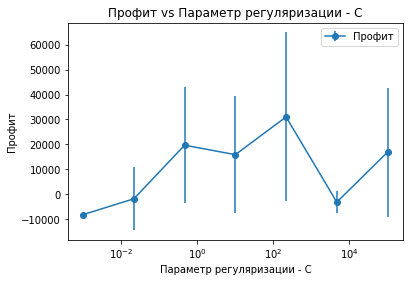

In [218]:
param_values = grid_search.cv_results_['param_classifier__C'].data
mean_profits = grid_search.cv_results_['mean_test_score']
std_profits = grid_search.cv_results_['std_test_score']

plt.errorbar(param_values, mean_profits, yerr=std_profits, fmt='-o', label='Профит')
plt.xscale('log')
plt.xlabel('Параметр регуляризации - С')
plt.ylabel('Профит')
plt.title('Профит vs Параметр регуляризации - С')
plt.legend()
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [220]:
param_grid = {'classifier__C': np.logspace(-3, 5, 7)}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=profit_scorer)

grid_search.fit(X, y)

print("Лучшие регуляризаторы (C):", grid_search.best_params_)
print("Лучший профит:", grid_search.best_score_)

Лучшие регуляризаторы (C): {'classifier__C': 10.0}
Лучший профит: 23690.520211179195


Нет, не всегда находится один и тот же лучший коэффициент! Это должно быть связано с случайными флуктуациями при разбиении данных на фолды, ведь под капотом GridSearchCV использует кросс-валидацию для оценки производительности модели и разбиение на фолды может ранжироваться.

Есть важная закономерность, которая указывает на то, что модель чувствительна к выбору коэффициента регуляризации, из-за постоянной вариации коэффа и возможно нужно более тщательно выбирать этот гиперпараметр!

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В данном случая я считаю, что более важна полнота, так как стоимость ложных отрицательных срабатываний высока, то есть лучше позвонить тому, кто заведомо даст отрицательный ответ, чем вообще не звонить!
Ориентируясь на (TP / (TP + FN))



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [231]:
thresholds = np.arange(0, 1.01, 0.01)

profit_mean = []
profit_std = []
best_thresholds = []

cvs = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

for threshold in thresholds:
    profits = []
    
    for id_train, id_test in cvs.split(X, y):
        X_train, X_test = X.iloc[id_train], X.iloc[id_test]
        y_train, y_test = y.iloc[id_train], y.iloc[id_test]
        
        pipeline.fit(X_train, y_train)
        
        probabilities = pipeline.predict_proba(X_test)[:, 1]
        prediction = (probabilities > threshold).astype(int)
        
        profit = calculate_profit(y_test, prediction)
        profits.append(profit)
        
    profit_mean.append(np.mean(profits))
    profit_std.append(np.std(profits))
    best_thresholds.append(thresholds[np.argmax(profit_mean)])

In [232]:
for i in range(len(thresholds)):
    print(f'Для порога={thresholds[i]} average Профит={profit_mean[i]}, std Профит={profit_std[i]}')

Для порога=0.0 average Профит=89787.88855755638, std Профит=51779.30401924164
Для порога=0.01 average Профит=100810.44180302454, std Профит=58450.76607516758
Для порога=0.02 average Профит=47319.912082397044, std Профит=32394.94254645186
Для порога=0.03 average Профит=48703.90989808777, std Профит=40667.99804715345
Для порога=0.04 average Профит=51683.50475282107, std Профит=34511.10494126869
Для порога=0.05 average Профит=34284.88261818238, std Профит=27969.50408974061
Для порога=0.06 average Профит=36106.346492578064, std Профит=16015.353000519008
Для порога=0.07 average Профит=37369.90629568328, std Профит=10664.178221935545
Для порога=0.08 average Профит=22090.72763511136, std Профит=16042.31901835226
Для порога=0.09 average Профит=18648.712580328363, std Профит=14101.157528567917
Для порога=0.1 average Профит=15866.793751450761, std Профит=12484.285305865205
Для порога=0.11 average Профит=15187.534077745533, std Профит=11032.01194427849
Для порога=0.12 average Профит=6599.99657360

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [234]:
best_threshold = best_thresholds[np.argmax(profit_mean)]
best_threshold

0.01

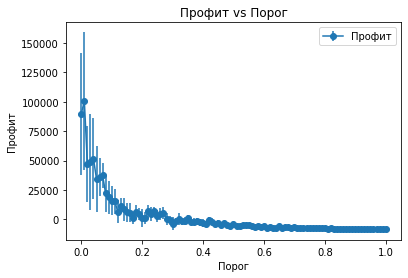

In [236]:
plt.errorbar(thresholds, profit_mean, yerr=profit_std, fmt='-o', label='Профит')
plt.xlabel('Порог')
plt.ylabel('Профит')
plt.title('Профит vs Порог')
plt.legend()
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Ну тут есть единственная очевидная закономерность, связанная с предпочтением в выборе между recall и presission(**Профит падает с ростом порога**). Чем больше порог, тем точнее мы предсказываем, но страдает полнота, значит в силу наших предпочтений о доминации важности recall над precision, выгодно взять оптимальный порог до 0.2, в силу заметно падующего тренда на протяжении всего графика.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [240]:
threshold = best_threshold

profit_mean = []
profit_std = []
precisions = []
recalls = []

cvs = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

profits = []
i = 1
for id_train, id_test in cvs.split(X, y):
    X_train, X_test = X.iloc[id_train], X.iloc[id_test]
    y_train, y_test = y.iloc[id_train], y.iloc[id_test]

    pipeline.fit(X_train, y_train)

    probabilities = pipeline.predict_proba(X_test)[:, 1]
    prediction = (probabilities > threshold).astype(int)

    profit = calculate_profit(y_test, prediction)
    profits.append(profit)
    
    precision, recall, _ = precision_recall_curve(y_test, prediction)
    precisions.append(precision)
    recalls.append(recall)

precisions_mean = np.mean(precisions)
precisions_std = np.std(precisions)
recalls_mean = np.mean(recalls)
recalls_std = np.std(recalls)

profit_mean = np.mean(profits)
profit_std = np.std(profits)

print(f'Precision на пороге {threshold} равен {precisions_mean}, и его стандартное отклонение {precisions_std}')
print(f'Recall на пороге {threshold} равен {recalls_mean}, и его стандартное отклонение {recalls_std}')

Precision на пороге 0.01 равен 0.4084488832035756, и его стандартное отклонение 0.41828980651694603
Recall на пороге 0.01 равен 0.6666666666666666, и его стандартное отклонение 0.47140452079103173


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [241]:
from sklearn.metrics import auc

In [251]:
thresholds = np.arange(0, 1.01, 0.01)

profit_mean = []
profit_std = []
best_thresholds = []
precisions_mean = []
precisions_std = []
recalls_mean = []
recalls_std = []
pr_auc = []

cvs = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

for threshold in thresholds:
    profits = []
    precisions = []
    recalls = []
    
    for id_train, id_test in cvs.split(X, y):
        X_train, X_test = X.iloc[id_train], X.iloc[id_test]
        y_train, y_test = y.iloc[id_train], y.iloc[id_test]

        pipeline.fit(X_train, y_train)

        probabilities = pipeline.predict_proba(X_test)[:, 1]
        prediction = (probabilities > threshold).astype(int)

        precision, recall, _ = precision_recall_curve(y_test, prediction)
        precisions.append(precision)
        recalls.append(recall)
        
        profit = calculate_profit(y_test, prediction)
        profits.append(profit)
    
    # индекс макс recall-а среди 5 фолдов
    max_recall_id = 0
    max_recall = 0.0
    for i in range(len(recalls)):
        if (np.mean(recalls[i]) > max_recall and  np.mean(recalls[i]) >= 0.5):
            max_recall = np.mean(recalls[i])
            max_recall_id = i
    
    precisions_mean.append(np.mean(precisions[max_recall_id]))
    precisions_std.append(np.std(precisions[max_recall_id]))
    recalls_mean.append(np.mean(recalls[max_recall_id]))
    recalls_std.append(np.std(recalls[max_recall_id]))
    pr_auc.append(auc(precisions[max_recall_id], recalls[max_recall_id]))

    profit_mean.append(np.mean(profits[max_recall_id]))
    profit_std.append(np.std(profits[max_recall_id]))
    best_thresholds.append(thresholds[np.argmax(profit_mean)])

In [254]:
# pr_auc

In [255]:
print(f'Precision={np.mean(precisions_mean)}')
print(f'Recall={np.mean(recalls_mean)}')
print(f'AUC-PR={np.mean(pr_auc)}')

Precision=0.5634933601074643
Recall=0.4552463867076363
AUC-PR=0.3948567691306488


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here

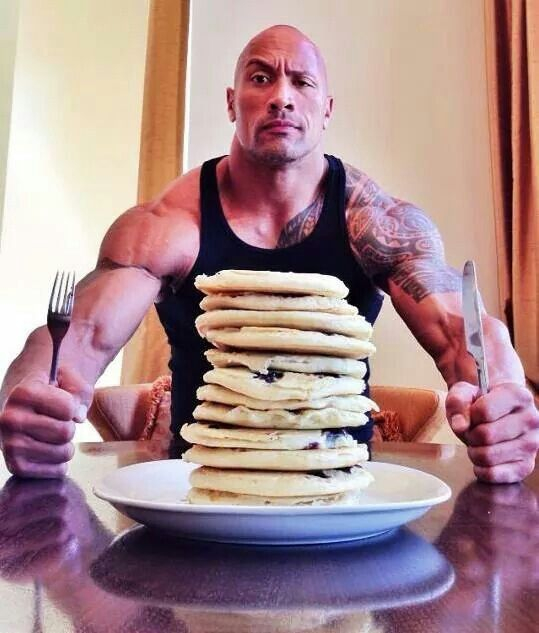